In [269]:
import numpy as np
from numpy import arange,array,ones,linalg
import math as m
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets
from astropy import utils, io
from astropy.io import fits
from astropy.table import Table, vstack, join

from sklearn.cluster import DBSCAN

Define function to plot DBSCAN results

In [15]:
def plot_dbscan(X,db,pltt,data=[]): #pltt=plt if plotting alone

    labels = db.labels_ #list of object's cluster labels; -1 = outlier
    core_samples_mask = np.zeros_like(labels, dtype=bool) #returns array of zeros of length len(labels)
    core_samples_mask[db.core_sample_indices_] = True #if object is core sample,make it "True" instead of "False"
    unique_labels=set(labels) #unique cluster labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # give each cluster a color, black is removed and used for noise.
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(10,10))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor=(0,0,0,.5), markersize=6)

        xy = X[class_member_mask & ~core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor='k', markersize=6)

    if pltt==plt:
        pltt.title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))
    else: pltt.set_title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))

In [16]:
file='/net/dl1/dlusers/katiefasbender/dat_m.fits' 
hdul=fits.open(file)
dat_m=hdul[1].data
Xx=np.column_stack((dat_m['ra'],dat_m['dec']))

## DBSCAN on all measurements, then on outliers

In [26]:
#Compute DBSCAN -----------------------------------------------------------------------------------------
db_1 = DBSCAN(eps=0.000138889, min_samples=2).fit(Xx)

#Get outliers -------------------------------------------------------------------------------------------
outliers=db_1.labels_==-1 #define outliers from DBSCAN labels
X_out=np.column_stack((np.array(dat_m['ra'][outliers]),np.array(dat_m['dec'][outliers]))) #coordinates of DBSCAN outliers

#Compute DBSCAN on outliers-------------------------------------------------------------------------------
db_2 = DBSCAN(eps=.001, min_samples=3).fit(X_out) #min_samples=3 so at least 3 mmts in a tracklet
labs = db_2.labels_ #cluster labels

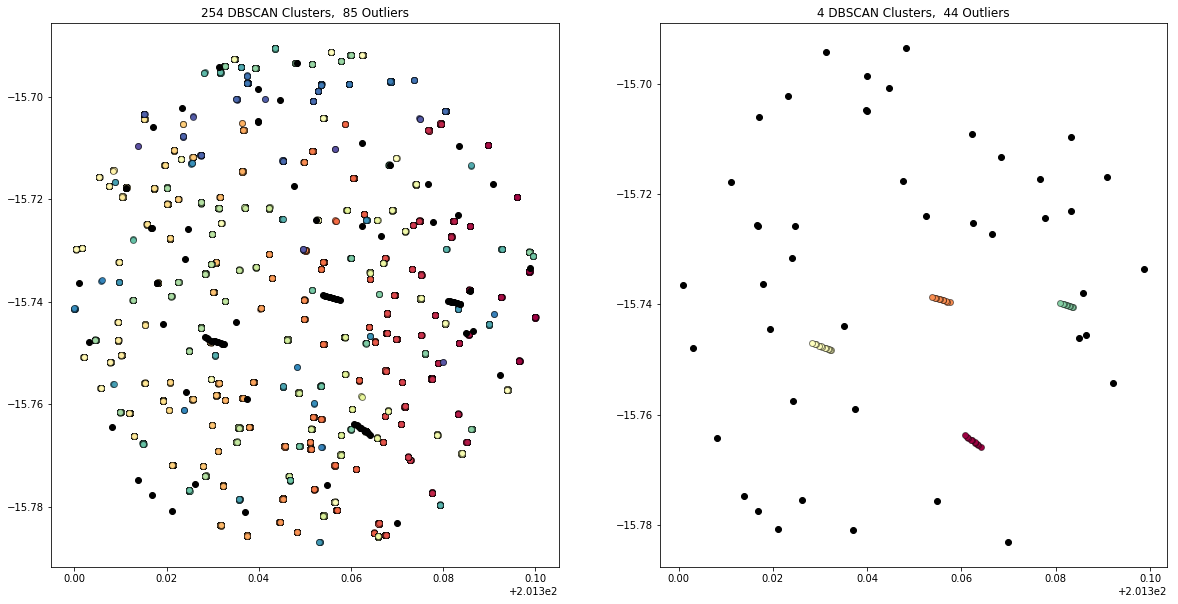

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [27]:
#plot DBSCAN on all measurements, and DBSCAN on outliers
f,(ax1,ax2)= plt.subplots(1, 2,figsize=(20,10)) 
plot_dbscan(Xx,db_1,ax1)
plot_dbscan(X_out,db_2,ax2)
plt.show()

## Select Cluster #0 from outlier DBSCAN, add time-outlier "data" to test tracklet validation

In [36]:
dat_m_t=Table(dat_m)
#Cluster #0 with one extra mmt a day later----------------------------------------------------------
c_ex=dat_m_t[outliers][labs==0]
c_ex.add_row(c_ex[4])
c_ex[10]['mjd']=c_ex[10]['mjd']+0.05
c_ex[10]['dec']=c_ex[10]['dec']+.0001
#Cluster #0 with extra stationary object------------------------------------------------------------
c_s=dat_m_t[outliers][labs==0]
c_s[:]['ra'] = 201.362285390197
c_s[:]['dec'] = -15.76465803771
c_s[:]['mag_auto'] = 20.1
c_so=join(c_s,dat_m_t[outliers][labs==0],join_type='outer')

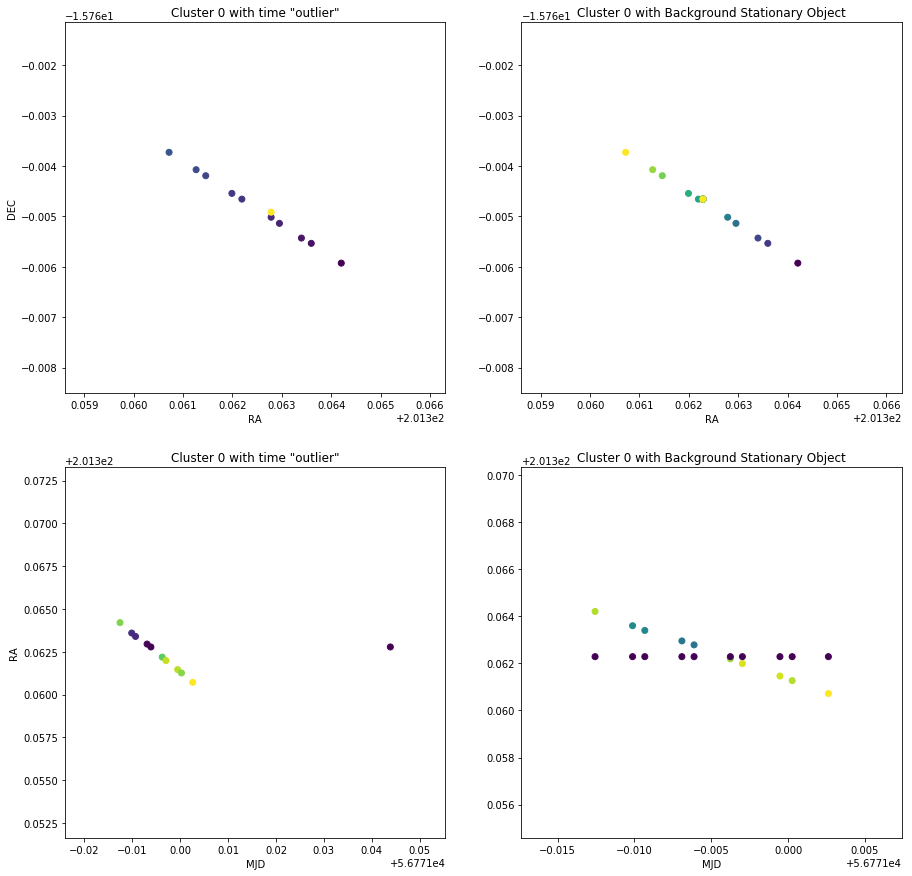

In [95]:
#plot clusters with added data; RA vs DEC, color = time (mjd)-------------------
f, ax = plt.subplots(2, 2, figsize=(15,15)) 
ax[0,0].scatter(c_ex['ra'],c_ex['dec'],c=c_ex['mjd'])
ax[0,0].set_title('Cluster 0 with time-outlier')
ax[0,0].set_ylabel('DEC')
ax[0,0].set_xlabel('RA')
ax[0,0].margins(x=-.3,y=-.3)
ax[0,1].scatter(c_so['ra'],c_so['dec'],c=c_so['mjd'])
ax[0,1].set_title('Cluster 0 with Background Stationary Object')
ax[0,1].set_xlabel('RA')
ax[0,1].margins(x=-.3,y=-.3)
#plot clusters with added data; MJD vs RA, color = magnitude (mag_auto)----------
ax[1,0].scatter(c_ex['mjd'],c_ex['ra'],c=c_ex['mag_auto'])
ax[1,0].set_title('Cluster 0 with time-outlier')
ax[1,0].set_ylabel('RA')
ax[1,0].set_xlabel('MJD')
ax[1,1].set_title('Cluster 0 with Background Stationary Object')
ax[1,1].scatter(c_so['mjd'],c_so['ra'],c=c_so['mag_auto'])
ax[1,1].set_xlabel('MJD')
ax[1,1].margins(x=-.1,y=-.1)
plt.show()

## Robust Regression for Single Time-outlier
using RANSAC from scikit-learn

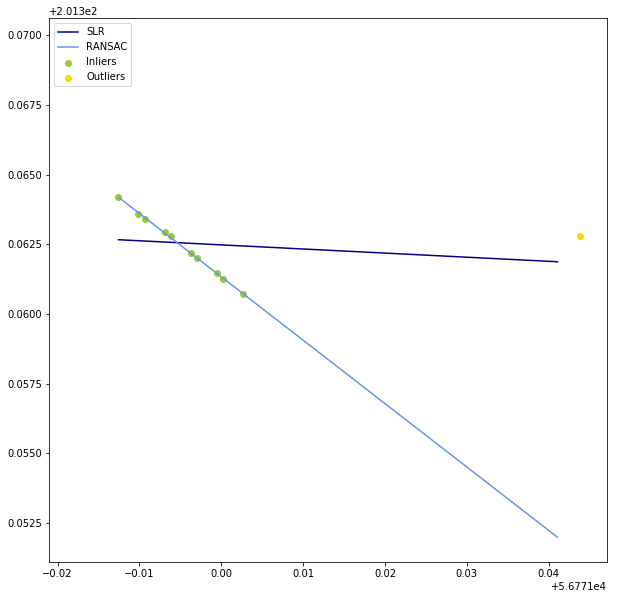

In [266]:
#Format data------------------------------------------------------------------------------
mjd=np.array(c_ex['mjd'])
X=np.reshape(mjd,(len(mjd),1))
y=np.array(c_ex['ra'])

# Fit SLR using all data------------------------------------------------------------------
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm-----------------------------------------
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models--------------------------------------------------------
line_X = np.reshape(np.arange(X.min(), X.max(),step=(X.max()-X.min())/20),(20,1))
line_y = lr.predict(line_X)  #line for SLR
line_y_ransac = ransac.predict(line_X) #line for RANSAC fit

#Plot results-----------------------------------------------------------------------------
plt.figure(figsize=(10,10))
#plot points (green for main data, yellow for outliers)
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', label='Outliers')
#plot SLR
plt.plot(line_X, line_y, color='navy', label='SLR')
#plot RANSAC line
plt.plot(line_X, line_y_ransac, color='cornflowerblue',label='RANSAC')
plt.legend(loc='upper left')
plt.show()

## Try same method on stationary background object 

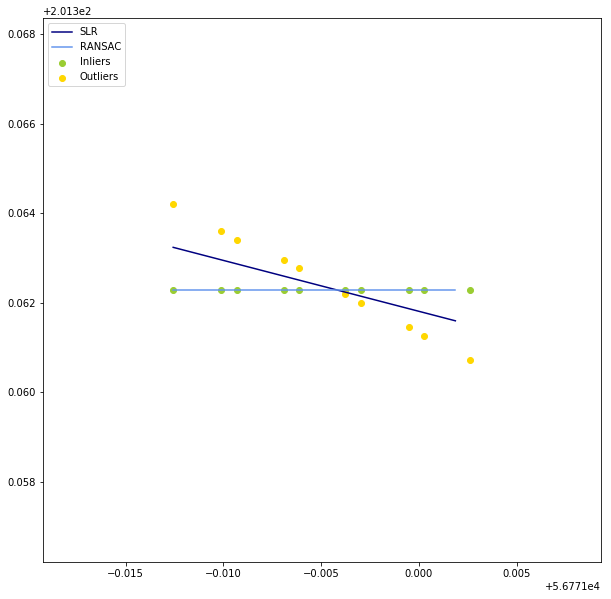

In [268]:
#Format data------------------------------------------------------------------------------
mjd=np.array(c_so['mjd'])
X=np.reshape(mjd,(len(mjd),1))
y=np.array(c_so['ra'])

# Fit SLR using all data------------------------------------------------------------------
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm-----------------------------------------
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models--------------------------------------------------------
line_X = np.reshape(np.arange(X.min(), X.max(),step=(X.max()-X.min())/20),(20,1))
line_y = lr.predict(line_X)  #line for SLR
line_y_ransac = ransac.predict(line_X) #line for RANSAC fit

#Plot results-----------------------------------------------------------------------------
plt.figure(figsize=(10,10))
#plot points (green for main data, yellow for outliers)
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', label='Outliers')
#plot SLR
plt.plot(line_X, line_y, color='navy', label='SLR')
#plot RANSAC line
plt.plot(line_X, line_y_ransac, color='cornflowerblue',label='RANSAC')
plt.legend(loc='upper left')
plt.show()

RANSAC treats measurements of the moving object as outliers, but effectively separates the moving and stationary objects.

Method adapted from https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py